In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import pickle
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as TF
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
#from torch.autograd import grad

from sklearn.cluster import KMeans

In [42]:
def smearedness(M):
    S=[]
    for i in range(20):
        S.append(sort(M.transpose()[i])[:-1].sum())
    return numpy.array(S)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [216]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
N=100
COL=dict()
collectorF=dict()
collectorS=dict()
for d in dr:
    F=[]
    S=[]
    for n in range(100):
        try:
            dataFSGM=pickle.load(open("data100/accFSGM_MSE_k0_do{0}_rep{1}.p".format(d,n),"rb"))
            dataSHM=pickle.load(open("data100/SHM_MSE_k0_do{0}_rep{1}.p".format(d,n),"rb"))
            F.append(mean(dataFSGM))
            S.append(mean(smearedness(dataSHM[2])))
            collectorF["{0} {1}".format(d,n)]=mean(dataFSGM)
            collectorS["{0} {1}".format(d,n)]=mean(smearedness(dataSHM[2]))
        except Exception:
            print("missing:",d,n)
    COL[d]=[F,S]

missing: 0.3 24
missing: 0.3 49


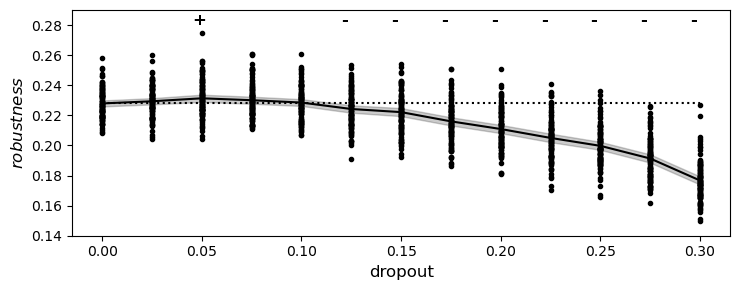

In [66]:
figure(figsize=[7.5,3])
M=[]
S=[]
sig=[]
Fs=[]
for d in dr:
    F,SM=COL[d]
    Fs.append(F)
    plot([d]*len(F),F,'k.')
    M.append(mean(F))
    S.append(mean_confidence_interval(F))
    #s,p=stats.kstest(Fs[0],Fs[-1])
    s,p=stats.mannwhitneyu(Fs[0],Fs[-1])
    if p<0.05:
        if M[-1]<M[0]:
            sig.append("-")
        else:
            sig.append("+")
    else:
        sig.append("")
    text(d-0.005,0.28,sig[-1],fontsize=12,fontweight='bold')
ylim(0.14,0.29)
M=numpy.array(M)
S=numpy.array(S)
plot(dr,M,'-k')
plot([dr[0],dr[-1]],[M[0],M[0]],':k')
fill_between(dr,M-S,M+S,color='k',alpha=0.2)
xlabel("dropout",fontsize=12)
ylabel(r"$robustness$",fontsize=12)
tight_layout()
savefig("foolingOverDo.pdf")

0.0 1.0
0.025 0.21678097888320502
0.05 0.35633076069146197
0.075 0.0018758683827533095
0.1 6.30622154753185e-05
0.125 2.5788051817820367e-07
0.15 2.0438252679583894e-05
0.175 1.3530310584616059e-06
0.2 4.225152730916788e-09
0.225 2.3845978820685445e-07
0.25 1.8357148260823679e-06
0.275 0.09539259270073754
0.3 0.5708434995609717
SpearmanrResult(correlation=-0.16773662423516664, pvalue=1.1982154208464863e-09)


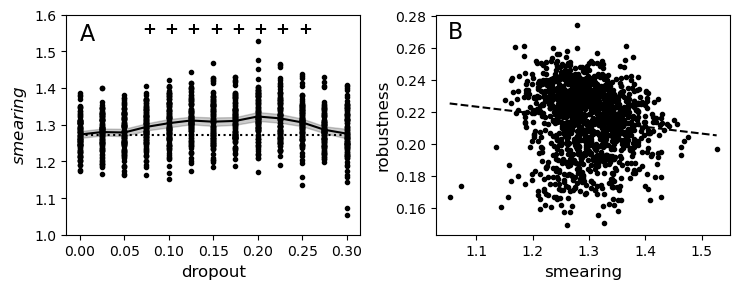

In [158]:
figure(figsize=[7.5,3])
subplot(1,2,1)
M=[]
S=[]
sig=[]
Fs=[]
for d in dr:
    SM,F=COL[d]
    Fs.append(F)
    plot([d]*len(F),F,'k.')
    M.append(mean(F))
    S.append(mean_confidence_interval(F))
    #s,p=stats.kstest(Fs[0],Fs[-1])
    s,p=stats.mannwhitneyu(Fs[0],Fs[-1])
    print(d,p)
    if p<0.05:
        if M[-1]<M[0]:
            sig.append("-")
        else:
            sig.append("+")
    else:
        sig.append("")
    text(d-0.005,1.55,sig[-1],fontsize=12,fontweight='bold')
ylim(1.0,1.6)
M=numpy.array(M)
S=numpy.array(S)
plot(dr,M,'-k')
plot([dr[0],dr[-1]],[M[0],M[0]],':k')
fill_between(dr,M-S,M+S,color='k',alpha=0.2)
xlabel("dropout",fontsize=12)
ylabel(r"$smearing$",fontsize=12)
text(0.0,1.53,"A",fontsize=16)
subplot(1,2,2)
who=[]
allF=[]
allS=[]
allD=[]
for d in dr:
    F,S=COL[d]
    allF+=F
    allS+=S
    allD+=[d]*len(S)
    for i in range(100):
        who.append([d,i])
plot(allS,allF,'.k')
v=numpy.polyfit(allS,allF,1)
x=linspace(min(allS),max(allS),11)
print(stats.spearmanr(allS,allF))
plot(x,numpy.polyval(v,x),'--k')
xlabel('smearing',fontsize=12)
ylabel('robustness',fontsize=12)
text(1.05,0.266,"B",fontsize=16)
tight_layout()
savefig("smearingOverDo.pdf")

In [11]:
def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    for i,r in enumerate(res):
        for e in r:
            V[e]+=H[0]-H[i]

    #V=sqrt(V)
    #V=V*V
    if V.sum()==0:
        return V
    return V/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(10):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

def smearedness(M):
    S=[]
    for i in range(20):
        S.append(sort(M.transpose()[i])[:-1].sum())
    return numpy.array(S)

SpearmanrResult(correlation=-0.05728504922204195, pvalue=0.039363138085774)
[-0.00396595  0.2205929 ]
SpearmanrResult(correlation=-0.12838068530744773, pvalue=3.6065345897465567e-06)
[-0.04235312  0.27018841]
SpearmanrResult(correlation=-0.12838068530744773, pvalue=3.6065345897465567e-06)
[-0.04235312  0.27018841]


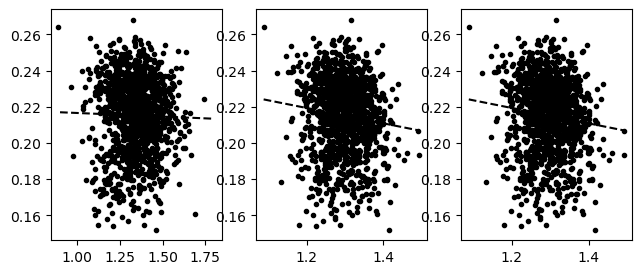

In [31]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
N=100
COL=dict()
smNotNorm=[]
smVNorm=[]
smTotalNorm=[]
fo=[]
for d in dr:
    for n in range(100):
        try:
            S,H,M=pickle.load(open("dataNoV/SHM_MSE_k0_do{0}_rep{1}.p".format(d,n),"rb"))
            dataFSGM=pickle.load(open("dataNoV/accFSGM_MSE_k0_do{0}_rep{1}.p".format(d,n),"rb"))
            fo.append(mean(dataFSGM))
            M2=removalIntoMatrix(S,20,H)
            smNotNorm.append(mean(smearedness(M)))
            smVNorm.append(mean(smearedness(M2)))
            smTotalNorm.append(mean(smearedness(M2/M2.max())))
        except Exception:
            pass
figure(figsize=[7.5,3])
subplot(1,3,1)
plot(smNotNorm,fo,'.k')
print(stats.spearmanr(smNotNorm,fo))
v=numpy.polyfit(smNotNorm,fo,1)
x=linspace(0.9,1.8,11)
plot(x,numpy.polyval(v,x),'--k')
print(v)

subplot(1,3,2)
plot(smVNorm,fo,'.k')
print(stats.spearmanr(smVNorm,fo))
v=numpy.polyfit(smVNorm,fo,1)
x=linspace(min(smVNorm),max(smVNorm),11)
plot(x,numpy.polyval(v,x),'--k')
print(v)
      
subplot(1,3,3)
plot(smTotalNorm,fo,'.k')
print(stats.spearmanr(smTotalNorm,fo))
v=numpy.polyfit(smTotalNorm,fo,1)
x=linspace(min(smTotalNorm),max(smTotalNorm),11)
plot(x,numpy.polyval(v,x),'--k')
print(v)


In [99]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
N=100
testR=[]
trainR=[]
testR_e=[]
trainR_e=[]
model=ComposedNet(28*28,20,10)
for d in dr:
    Wtest=[]
    Wtrain=[]
    for i in range(10):
        Wtest.append([])
        Wtrain.append([])
    for n in range(100):
        try:
            model.load_state_dict(torch.load("data100_model/fullModel_MSE_k0_do{0}_rep{1}.model".format(d,n)))
            trainAT=testOnAllTen(model,imageNumberDataSet)
            testAT=testOnAllTen(model,testImageNumberDataSet,howMany=800)
            for i in range(10):
                Wtrain[i].append(trainAT[i])
                Wtest[i].append(testAT[i])
        except Exception:
            print("missing",d,n)
    trainR.append(numpy.array(Wtrain).mean(1))
    testR.append(numpy.array(Wtest).mean(1))
    trainR_e.append(mean_confidence_interval(transpose(Wtrain)))
    testR_e.append(mean_confidence_interval(transpose(Wtest)))

missing 0.3 24
missing 0.3 49


In [ ]:
trainR=numpy.array(trainR).transpose()
testR=numpy.array(testR).transpose()
trainR_e=numpy.array(trainR_e).transpose()
testR_e=numpy.array(testR_e).transpose()


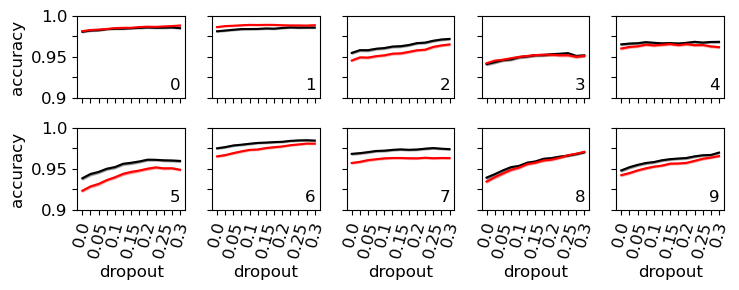

In [140]:

figure(figsize=[7.5,3])
for i in range(10):
    subplot(2,5,i+1)
    fill_between(dr,trainR[i]-trainR_e[i],trainR[i]+trainR_e[i],color='k',alpha=0.3)
    plot(dr,trainR[i],'k')
    fill_between(dr,testR[i]-testR_e[i],testR[i]+testR_e[i],color='r',alpha=0.3)
    plot(dr,testR[i],"r")
    ylim(0.9,1)
    if i in [0,5]:
        ylabel("accuracy",fontsize=12)
        yticks([0.9,0.925,0.95,0.975,1.0],['0.9','','0.95','','1.0'],fontsize=12)
    else:
        yticks([0.9,0.925,0.95,0.975,1.0],['','','','',''],fontsize=12)
    if i <5:
        xticks(dr,[""]*len(dr))
    else:
        xticks(dr,['0.0','','0.05','','0.1','','0.15','','0.2','','0.25','','0.3'],fontsize=12,rotation=75)
        xlabel("dropout",fontsize=12)
    text(0.27,0.91,"{0}".format(i),fontsize=12)
tight_layout()
savefig("featureSpace.pdf")

In [106]:
model=ComposedNet(28*28,20,10)
model.load_state_dict(torch.load("data100_model/fullModel_MSE_k0_do0.05_rep11.model"))
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_single_ordered, eps)
    accuracies.append(acc)
    examples.append(ex)


-0.3 0.30000004


Text(0.5, 1.0, 'fooled')

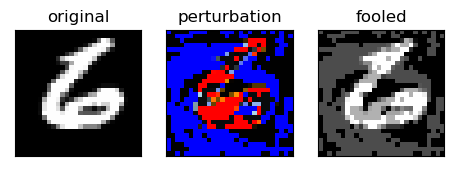

In [128]:
figure(figsize=[7.5,3])
O=original.detach().numpy().reshape((28,28))
M=perturbed.detach().numpy().reshape((28,28))
localCmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","orange","black","lightblue","blue"])

subplot(1,4,1)
imshow(O,cmap='gray')
xticks([])
yticks([])
title("original",fontsize=12)

subplot(1,4,2)
imshow(M-O,cmap=localCmap)
xticks([])
yticks([])
title("perturbation",fontsize=12)
print((M-O).min(),(M-O).max())
#colorbar(fraction=0.03)

subplot(1,4,3)
imshow(M,cmap='gray')
xticks([])
yticks([])
title("fooled",fontsize=12)


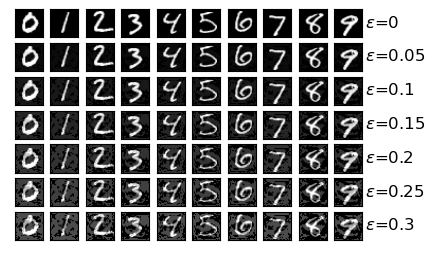

In [101]:
figure(figsize=[7.5*0.6,3])
whos=[3,2,1,28,6,14,10,0,80,8]
for e,eps in enumerate(epsilons):
    for i in range(10):
        subplot(7,10,(e*10)+i+1)
        imshow(PDs[e][whos[i]].detach().numpy().reshape((28,28)),cmap='gray')
        xticks([])
        yticks([])
        if i==9:
            text(30,17,r"$\epsilon$="+str(eps),fontsize=12)
#imshow()

-0.3 0.30000004


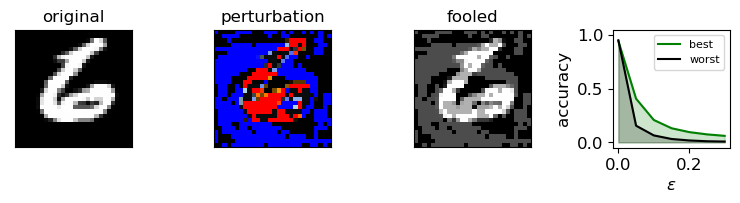

In [151]:
#figure(figsize=[7.5*0.4,3])
figure(figsize=[7.5,2])
O=original.detach().numpy().reshape((28,28))
M=perturbed.detach().numpy().reshape((28,28))
localCmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","orange","black","lightblue","blue"])

#subplot(1,4,1)
subplot2grid((1, 4), (0, 0), colspan=1)
imshow(O,cmap='gray')
xticks([])
yticks([])
title("original",fontsize=12)

#subplot(1,4,2)
subplot2grid((1, 4), (0, 1), colspan=1)
imshow(M-O,cmap=localCmap)
xticks([])
yticks([])
title("perturbation",fontsize=12)
print((M-O).min(),(M-O).max())
#colorbar(fraction=0.03)

#subplot(1,4,3)
subplot2grid((1, 4), (0, 2), colspan=1)
imshow(M,cmap='gray')
xticks([])
yticks([])
title("fooled",fontsize=12)

#subplot(1,4,4)
subplot2grid((1, 4), (0, 3), colspan=2)

B=pickle.load(open("data100/accFSGM_MSE_k0_do{0}_rep{1}.p".format(0.05,11),"rb"))
W=pickle.load(open("data100/accFSGM_MSE_k0_do{0}_rep{1}.p".format(0.3,44),"rb"))
epsilons = [0, .05, .1, .15, .2, .25, .3]
plot(epsilons,B,'g',label="best")
fill_between(epsilons,[0.0]*len(epsilons),B,color='g',alpha=0.2)
plot(epsilons,W,'k',label="worst")
fill_between(epsilons,[0.0]*len(epsilons),W,color='k',alpha=0.2)
ylim(-0.05,1.05)
xlabel(r"$\epsilon$",fontsize=12)
ylabel("accuracy",fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
legend(fontsize=8)
tight_layout()
savefig("exampleFSGM.pdf")

In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [11]:
def test( model, test_loader, epsilon ,verbose=False,device="cpu"):
    global original
    global perturbed
    # Accuracy counter
    correct = 0
    adv_examples = []
    PD=[]
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        original=data
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = TF.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed = perturbed_data
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples



In [175]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_single, eps)
    accuracies.append(acc)
    examples.append(ex)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
train_single =torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])),
        batch_size=1, shuffle=True)
train_batch =torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1000, shuffle=True)
train_full = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=60000, shuffle=True)
test_full = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10000, shuffle=True)
test_single = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
test_single_ordered = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=False)

imageNumberDataSet=[]
for i in range(10):
    imageNumberDataSet.append([])
for images,targets in train_full:
    for i in range(60000):
        imageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    imageNumberDataSet[i]=numpy.array(imageNumberDataSet[i])
    print(i,imageNumberDataSet[i].shape)

testImageNumberDataSet=[]
for i in range(10):
    testImageNumberDataSet.append([])
for images,targets in test_full:
    for i in range(10000):
        testImageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    testImageNumberDataSet[i]=numpy.array(testImageNumberDataSet[i])
    print(i,testImageNumberDataSet[i].shape)

0 (5923, 1, 28, 28)
1 (6742, 1, 28, 28)
2 (5958, 1, 28, 28)
3 (6131, 1, 28, 28)
4 (5842, 1, 28, 28)
5 (5421, 1, 28, 28)
6 (5918, 1, 28, 28)
7 (6265, 1, 28, 28)
8 (5851, 1, 28, 28)
9 (5949, 1, 28, 28)
0 (980, 1, 28, 28)
1 (1135, 1, 28, 28)
2 (1032, 1, 28, 28)
3 (1010, 1, 28, 28)
4 (982, 1, 28, 28)
5 (892, 1, 28, 28)
6 (958, 1, 28, 28)
7 (1028, 1, 28, 28)
8 (974, 1, 28, 28)
9 (1009, 1, 28, 28)


In [4]:
def testOnAllTen(model,imageNumberDataSet,howMany=1000):
    images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2,3,4,5,6,7,8,9],[howMany]*10,randomizeOrder=False)
    numberIDsOther=[[],[],[],[],[],[],[],[],[],[]]
    numberIDsThis=[[],[],[],[],[],[],[],[],[],[]]
    for i in range(10):
        for j in range(10):
            I=list(range(j*howMany,(j+1)*howMany))
            if j!=i:
                numberIDsOther[i]+=I
            else:
                numberIDsThis[i]+=I
    numberIDsThis=numpy.array(numberIDsThis)
    numberIDsOther=numpy.array(numberIDsOther)
    output=2.0*(model(torch.tensor(images)).detach().numpy().transpose()>0.0)-1.0
    C=list()
    targets=targets.transpose()
    for n in range(10):
        otherID=numpy.random.choice(numberIDsOther[n],(howMany),replace=False)
        TP=(1.0*(targets[n][numberIDsThis[n]]==output[n][numberIDsThis[n]])).sum()
        TN=(1.0*(targets[n][otherID]==output[n][otherID])).sum()
        C.append((TP+TN)/(howMany+howMany))
        #print(ids.shape)
    return C

0 (5923, 1, 28, 28)
1 (6742, 1, 28, 28)
2 (5958, 1, 28, 28)
3 (6131, 1, 28, 28)
4 (5842, 1, 28, 28)
5 (5421, 1, 28, 28)
6 (5918, 1, 28, 28)
7 (6265, 1, 28, 28)
8 (5851, 1, 28, 28)
9 (5949, 1, 28, 28)
0 (980, 1, 28, 28)
1 (1135, 1, 28, 28)
2 (1032, 1, 28, 28)
3 (1010, 1, 28, 28)
4 (982, 1, 28, 28)
5 (892, 1, 28, 28)
6 (958, 1, 28, 28)
7 (1028, 1, 28, 28)
8 (974, 1, 28, 28)
9 (1009, 1, 28, 28)


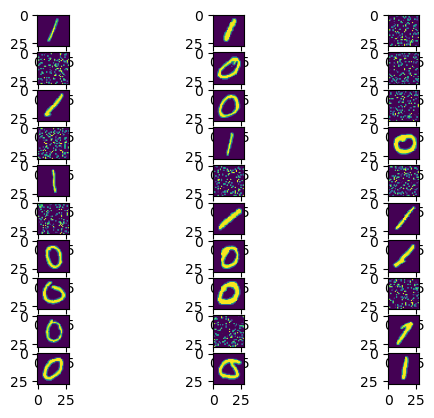

In [5]:
def makeCFtrainSet(imageNumber,numbers,n,randomizeOrder=True,scrambleNumbers=[]):
    for i,number in enumerate(numbers):
        T=numpy.zeros((10,n[i]))-1.0
        T[number]=numpy.ones((n[i]))
        T=T.transpose()
        I=numpy.array([number]*n[i])
        which=numpy.random.choice(range(len(imageNumber[number])),(n[i]),replace=False)
        if number==numbers[0]:
            images=numpy.array(imageNumber[number][which])
            if number in scrambleNumbers:
                originalShape=images.shape
                images=images.flatten()
                numpy.random.shuffle(images)
                images=images.reshape(originalShape)
            targets=T
            ids=I
        else:
            toAdd=imageNumber[number][which]
            if number in scrambleNumbers:
                originalShape=toAdd.shape
                toAdd=toAdd.flatten()
                numpy.random.shuffle(toAdd)
                toAdd=toAdd.reshape(originalShape)
            images=numpy.concatenate((images,toAdd))
            targets=numpy.concatenate((targets,T))
            ids=numpy.concatenate((ids,I))
    if randomizeOrder:
        order=numpy.random.choice(range(images.shape[0]),(images.shape[0]),replace=False)
        images=images[order]
        targets=targets[order]
        ids=ids[order]
    return images,targets,ids

imageNumberDataSet=[]
for i in range(10):
    imageNumberDataSet.append([])
for images,targets in train_full:
    for i in range(60000):
        imageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    imageNumberDataSet[i]=numpy.array(imageNumberDataSet[i])
    print(i,imageNumberDataSet[i].shape)

testImageNumberDataSet=[]
for i in range(10):
    testImageNumberDataSet.append([])
for images,targets in test_full:
    for i in range(10000):
        testImageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    testImageNumberDataSet[i]=numpy.array(testImageNumberDataSet[i])
    print(i,testImageNumberDataSet[i].shape)
    
images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2],[10,10,10],scrambleNumbers=[2])
for i in range(30):
    subplot(10,3,i+1)
    imshow(images[i][0])

In [6]:
class ComposedNet(nn.Module):
    def __init__(self, input_dim=28*28,hidden_dim=50,output_dim=10,dropout_p=0.0):
        super(ComposedNet, self).__init__()
        self.hiddenLayer=nn.Linear(input_dim,hidden_dim)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
        self.output_dim=output_dim
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.do=nn.Dropout(dropout_p)
        
    def forward(self, x):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(self.do(out)))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def forwardWithNodeNoise(self, x,nodes,theVar=0.1):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(out))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        l=out.shape[0]
        out=torch.transpose(out,0,1).detach().numpy()
        for node in nodes:
            out[node]+=numpy.random.uniform(0.0,theVar,(l))
        out=torch.transpose(torch.tensor(out),0,1)
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def stepBlock(self,x,nodes,block):
        out=x.view(-1,28*28)
        out=torch.tanh(self.hiddenLayer(out))
        out=torch.transpose(out,0,1)
        for node in nodes:
            out[node]=torch.Tensor(block.transpose()[node])
        out=torch.transpose(out,0,1)
        out=torch.tanh(self.outputLayer(out))
        return out
    
    def BackUpWeights(self):
        self.BUweights=copy.deepcopy(self.state_dict())
        
    def block(self,nodes):
        weights=self.state_dict()
        #print(weights["outputLayer.weight"].shape)
        for node in nodes:
            weights["hiddenLayer.weight"][node]=torch.Tensor(numpy.zeros((weights["hiddenLayer.weight"].shape[1])))
            weights["hiddenLayer.bias"][node]=0.0
            for i in range(self.output_dim):
                weights["outputLayer.weight"][i][node]=0.0
        self.load_state_dict(weights)
        
    def toneDownGradients(self,dampening):
        self.hiddenLayer.weight.grad=torch.Tensor((self.hiddenLayer.weight.grad.detach().numpy().transpose()*dampening).transpose())
        self.hiddenLayer.bias.grad*=torch.Tensor(dampening)
        for i in range(self.output_dim):
            self.outputLayer.weight.grad[i]*=torch.Tensor(dampening)
            
    def induceDropout(self,p):
        self.hiddenLayer.weight.grad*=torch.Tensor(1.0*(numpy.random.random((self.hiddenLayer.weight.grad.shape))>p))
        self.hiddenLayer.bias.grad  *=torch.Tensor(1.0*(numpy.random.random((self.hiddenLayer.bias.grad.shape))>p))
        self.outputLayer.weight.grad*=torch.Tensor(1.0*(numpy.random.random((self.outputLayer.weight.grad.shape))>p))
        self.outputLayer.bias.grad*=torch.Tensor(1.0*(numpy.random.random((self.outputLayer.bias.grad.shape))>p))
    
model=ComposedNet(hidden_dim=20)

In [167]:
def makeSingleTrainingSet(train_single,forNumber,n=5000):
    pos=0
    neg=0
    images=[]
    targets=[]
    for image,target in train_single:
        if target.item()==forNumber and pos<n:
            images.append(image.detach().numpy().reshape((28,28)))
            targets.append([1.0])
            pos+=1
        if target.item()!=forNumber and neg<n:
            images.append(image.detach().numpy().reshape((28,28)))
            neg+=1
            targets.append([-1.0])
    return numpy.array(images),numpy.array(targets)

images,targets=makeSingleTrainingSet(train_single,0)

In [23]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def RwithoutS(I,H,Hmask,iMult=2):
    A=I
    B=numpy.bitwise_and(H,Hmask)
    AB=B*iMult+I
    hA=symbolEntropy(A,base=2)
    hB=symbolEntropy(B,base=2)
    hAB=symbolEntropy(AB,base=2)
    return hA+hB-hAB
    
def getOutTaH(model,dataSet,width=20):
    for batch_idx, (d, t) in enumerate(dataSet):
        o = model(d)#+torch.Tensor(numpy.random.uniform(0.0,0.1,d.shape)))
        h=model.hidden
        data=d
        target=t.detach().numpy()
        output=o.detach().numpy()
        hidden=numpy.array(model.hidden[0])

        A=hidden.transpose()
        
    B=numpy.zeros(A.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=A[i].reshape(-1,1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(A[i]>numpy.median(A[i]))


    H=numpy.zeros((target.shape))
    for i in range(width):
        H+=B[i]*(2**i)
    H=H.astype((int))
    return output,target,H
    
def singleShrinkingDecompositionInformation(I,H,width=20):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            mask=0
            for s in subset:
                mask+=1*(2**s)
            mask=int(mask)
            h=RwithoutS(I,H,mask)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def shrinkingDecompositionInformation(model,width,dataSet,numbers=[0,1,2,3,4,5,6,7,8,9]):
    output,target,H=getOutTaH(model,dataSet,width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1.0*(target==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    for i,r in enumerate(res):
        for e in r:
            V[e]+=H[0]-H[i]

    #V=sqrt(V)
    #V=V*V
    if V.sum()==0:
        return V
    return V/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(10):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

def smearedness(M):
    S=[]
    for i in range(M.shape[1]):
        S.append(sort(M.transpose()[i])[:-1].sum())
    return numpy.array(S)

In [ ]:
#This code trains the composed model and tests it

In [7]:
#create networks of different sizes, to check performance and foolability later
!mkdir dataSize

In [7]:
for rep in range(30):
    for modelSize in [10,12,14,16,18,20,22,24,26,28,30]:
        model=ComposedNet(28*28,modelSize,10)
        optimizer = optim.Adam(model.parameters(),lr=0.001)
        error = nn.MSELoss()
        for epoch in range(20):
            for image,target in train_batch:
                optimizer.zero_grad()
                targets=numpy.zeros((1000,10))-1.0
                for i,t in enumerate(target):
                    targets[i][t]=1.0
                output = model(torch.Tensor(image))
                loss = error(output, torch.Tensor(targets))
                loss.backward()
                optimizer.step()
        torch.save(model,"dataSize/model_{0}_{1}.model".format(modelSize,rep))
        trainAT=testOnAllTen(model,imageNumberDataSet)
        testAT=testOnAllTen(model,testImageNumberDataSet,howMany=800)
        print("train",trainAT)        
        print("test",testAT)
        pickle.dump([trainAT,testAT],open("dataSize/W_{0}_{1}.p".format(modelSize,rep),'wb'))

train [0.9635, 0.971, 0.8945, 0.8995, 0.929, 0.814, 0.958, 0.9315, 0.7465, 0.9005]
test [0.9625, 0.980625, 0.893125, 0.90375, 0.94125, 0.82, 0.949375, 0.93625, 0.748125, 0.88875]
train [0.9745, 0.974, 0.9165, 0.8895, 0.9365, 0.8795, 0.9595, 0.9255, 0.83, 0.91]
test [0.9725, 0.97875, 0.915, 0.898125, 0.936875, 0.879375, 0.94, 0.925, 0.8525, 0.9025]
train [0.975, 0.9775, 0.921, 0.893, 0.9345, 0.883, 0.9565, 0.9375, 0.886, 0.882]
test [0.9775, 0.981875, 0.919375, 0.91625, 0.934375, 0.881875, 0.94625, 0.933125, 0.890625, 0.895]
train [0.9715, 0.9775, 0.9305, 0.9095, 0.944, 0.8945, 0.955, 0.9555, 0.8935, 0.9295]
test [0.97875, 0.97875, 0.92625, 0.919375, 0.95, 0.88875, 0.945625, 0.94875, 0.89875, 0.92]
train [0.977, 0.977, 0.9235, 0.924, 0.9515, 0.8885, 0.963, 0.9565, 0.9, 0.9275]
test [0.974375, 0.980625, 0.935, 0.930625, 0.955, 0.895625, 0.958125, 0.948125, 0.903125, 0.924375]
train [0.9785, 0.9795, 0.952, 0.9335, 0.9515, 0.9035, 0.969, 0.953, 0.922, 0.922]
test [0.979375, 0.98625, 0.935,

train [0.9645, 0.9785, 0.929, 0.921, 0.938, 0.8815, 0.968, 0.948, 0.8735, 0.9225]
test [0.97125, 0.979375, 0.92375, 0.920625, 0.935625, 0.8875, 0.963125, 0.940625, 0.88625, 0.914375]
train [0.981, 0.9765, 0.9235, 0.9175, 0.9495, 0.9045, 0.9655, 0.9505, 0.9235, 0.9185]
test [0.973125, 0.979375, 0.92625, 0.925625, 0.95, 0.895, 0.9575, 0.948125, 0.915625, 0.909375]
train [0.9695, 0.971, 0.923, 0.931, 0.949, 0.916, 0.958, 0.948, 0.8905, 0.919]
test [0.97125, 0.983125, 0.92625, 0.9325, 0.949375, 0.89375, 0.9425, 0.9425, 0.885625, 0.911875]
train [0.9755, 0.972, 0.9465, 0.926, 0.941, 0.898, 0.971, 0.961, 0.93, 0.9405]
test [0.983125, 0.980625, 0.935, 0.93125, 0.9475, 0.90625, 0.96375, 0.953125, 0.926875, 0.940625]
train [0.979, 0.9775, 0.9245, 0.9375, 0.946, 0.9285, 0.952, 0.9445, 0.903, 0.9395]
test [0.981875, 0.985625, 0.92875, 0.944375, 0.945, 0.916875, 0.958125, 0.9425, 0.896875, 0.93375]
train [0.98, 0.976, 0.949, 0.9335, 0.9565, 0.915, 0.9705, 0.9565, 0.912, 0.931]
test [0.980625, 0.98

train [0.972, 0.978, 0.938, 0.928, 0.9605, 0.9025, 0.9735, 0.9415, 0.9215, 0.9345]
test [0.979375, 0.985625, 0.9375, 0.930625, 0.954375, 0.910625, 0.96375, 0.94625, 0.915625, 0.9375]
train [0.981, 0.9775, 0.9455, 0.919, 0.9475, 0.9065, 0.964, 0.958, 0.9225, 0.937]
test [0.985625, 0.98375, 0.9325, 0.926875, 0.95625, 0.911875, 0.964375, 0.953125, 0.925625, 0.92875]
train [0.975, 0.979, 0.949, 0.932, 0.956, 0.912, 0.9695, 0.956, 0.9225, 0.95]
test [0.97875, 0.98625, 0.94625, 0.935625, 0.954375, 0.904375, 0.961875, 0.95125, 0.93125, 0.9325]
train [0.979, 0.9825, 0.95, 0.925, 0.958, 0.919, 0.962, 0.962, 0.929, 0.9425]
test [0.98, 0.985, 0.948125, 0.928125, 0.956875, 0.925, 0.95625, 0.95, 0.931875, 0.9275]
train [0.983, 0.9825, 0.9405, 0.9315, 0.952, 0.932, 0.977, 0.964, 0.9345, 0.932]
test [0.984375, 0.985625, 0.935, 0.93125, 0.96, 0.914375, 0.96, 0.961875, 0.924375, 0.92875]
train [0.9195, 0.9715, 0.907, 0.869, 0.9035, 0.8475, 0.951, 0.912, 0.838, 0.8615]
test [0.91375, 0.978125, 0.900625,

train [0.9785, 0.977, 0.937, 0.928, 0.9575, 0.94, 0.9775, 0.9555, 0.9105, 0.9435]
test [0.975, 0.99, 0.940625, 0.931875, 0.953125, 0.9225, 0.961875, 0.950625, 0.919375, 0.935625]
train [0.9795, 0.9785, 0.9455, 0.932, 0.966, 0.9325, 0.9715, 0.958, 0.9355, 0.9325]
test [0.9775, 0.985, 0.9325, 0.935, 0.964375, 0.915625, 0.960625, 0.9475, 0.925, 0.9475]
train [0.9745, 0.9785, 0.945, 0.934, 0.9645, 0.9265, 0.9655, 0.9615, 0.9315, 0.926]
test [0.9825, 0.985625, 0.94, 0.934375, 0.9625, 0.9275, 0.96375, 0.953125, 0.931875, 0.92375]
train [0.9585, 0.972, 0.8995, 0.9015, 0.92, 0.8705, 0.9575, 0.9275, 0.8385, 0.885]
test [0.965, 0.979375, 0.87125, 0.914375, 0.9175, 0.855625, 0.949375, 0.920625, 0.85, 0.8825]
train [0.957, 0.971, 0.8925, 0.894, 0.9175, 0.8285, 0.9425, 0.932, 0.8625, 0.8905]
test [0.960625, 0.9775, 0.88875, 0.88875, 0.92375, 0.829375, 0.93875, 0.92625, 0.84875, 0.890625]
train [0.9705, 0.9685, 0.899, 0.91, 0.897, 0.8485, 0.9425, 0.949, 0.826, 0.8795]
test [0.97, 0.971875, 0.905625,

train [0.982, 0.974, 0.9445, 0.945, 0.9525, 0.93, 0.9775, 0.9545, 0.939, 0.9395]
test [0.985, 0.985625, 0.94375, 0.939375, 0.955625, 0.915, 0.961875, 0.951875, 0.934375, 0.933125]
train [0.9495, 0.976, 0.876, 0.879, 0.915, 0.878, 0.9535, 0.9025, 0.805, 0.882]
test [0.9575, 0.981875, 0.86625, 0.883125, 0.908125, 0.85625, 0.9425, 0.909375, 0.800625, 0.8875]
train [0.962, 0.9625, 0.8895, 0.8665, 0.935, 0.869, 0.9375, 0.926, 0.886, 0.8875]
test [0.965, 0.965, 0.8925, 0.88125, 0.934375, 0.85875, 0.935, 0.9225, 0.89375, 0.885]
train [0.9705, 0.974, 0.9095, 0.8975, 0.94, 0.902, 0.9595, 0.948, 0.846, 0.9105]
test [0.965625, 0.98, 0.906875, 0.916875, 0.95125, 0.8975, 0.94125, 0.938125, 0.87, 0.920625]
train [0.9755, 0.9815, 0.9155, 0.9195, 0.9595, 0.9015, 0.9595, 0.94, 0.906, 0.918]
test [0.976875, 0.98625, 0.923125, 0.915625, 0.9575, 0.905625, 0.948125, 0.933125, 0.909375, 0.919375]
train [0.9795, 0.981, 0.9275, 0.919, 0.95, 0.897, 0.969, 0.937, 0.9135, 0.926]
test [0.975625, 0.984375, 0.92812

train [0.9645, 0.9725, 0.9255, 0.909, 0.9445, 0.8595, 0.9485, 0.941, 0.8275, 0.8875]
test [0.974375, 0.98, 0.91125, 0.920625, 0.949375, 0.86, 0.93625, 0.939375, 0.830625, 0.8875]
train [0.9605, 0.972, 0.931, 0.9185, 0.943, 0.8975, 0.957, 0.9495, 0.905, 0.9245]
test [0.9625, 0.979375, 0.931875, 0.91375, 0.954375, 0.8875, 0.94375, 0.941875, 0.906875, 0.920625]
train [0.968, 0.978, 0.9365, 0.927, 0.953, 0.9105, 0.9555, 0.945, 0.9005, 0.9315]
test [0.976875, 0.981875, 0.9325, 0.92875, 0.955, 0.901875, 0.958125, 0.93625, 0.90875, 0.92375]
train [0.978, 0.9715, 0.9285, 0.93, 0.9565, 0.892, 0.958, 0.9495, 0.879, 0.926]
test [0.98125, 0.985, 0.929375, 0.929375, 0.954375, 0.90375, 0.949375, 0.936875, 0.8925, 0.920625]
train [0.978, 0.9855, 0.9235, 0.939, 0.955, 0.9185, 0.9635, 0.948, 0.9015, 0.9255]
test [0.9775, 0.986875, 0.93625, 0.934375, 0.95625, 0.908125, 0.95625, 0.945, 0.903125, 0.918125]
train [0.976, 0.9745, 0.9355, 0.921, 0.963, 0.921, 0.958, 0.9565, 0.909, 0.9385]
test [0.980625, 0.9

train [0.9735, 0.9775, 0.94, 0.914, 0.9495, 0.9, 0.975, 0.9605, 0.908, 0.9375]
test [0.975625, 0.98875, 0.929375, 0.92625, 0.949375, 0.908125, 0.96375, 0.939375, 0.904375, 0.93125]
train [0.9755, 0.9765, 0.9435, 0.9195, 0.949, 0.9165, 0.96, 0.9495, 0.9175, 0.935]
test [0.98, 0.98625, 0.934375, 0.925, 0.951875, 0.91375, 0.9625, 0.94375, 0.91875, 0.925]
train [0.978, 0.98, 0.936, 0.9275, 0.9575, 0.914, 0.9665, 0.9445, 0.9325, 0.9405]
test [0.978125, 0.98375, 0.9375, 0.941875, 0.955, 0.914375, 0.95875, 0.944375, 0.936875, 0.935]
train [0.9755, 0.9815, 0.9395, 0.9205, 0.9545, 0.9155, 0.962, 0.955, 0.8975, 0.9355]
test [0.983125, 0.984375, 0.935, 0.929375, 0.950625, 0.916875, 0.951875, 0.948125, 0.90875, 0.925625]
train [0.979, 0.9775, 0.9515, 0.943, 0.9555, 0.924, 0.9735, 0.956, 0.9405, 0.9385]
test [0.9875, 0.98125, 0.945625, 0.94125, 0.95625, 0.9225, 0.96875, 0.948125, 0.93375, 0.936875]
train [0.9755, 0.9755, 0.949, 0.925, 0.959, 0.9325, 0.971, 0.962, 0.9355, 0.9305]
test [0.98125, 0.98

train [0.9735, 0.982, 0.943, 0.926, 0.9585, 0.9105, 0.96, 0.962, 0.912, 0.936]
test [0.9725, 0.985, 0.938125, 0.9325, 0.955625, 0.9075, 0.96125, 0.948125, 0.9075, 0.930625]
train [0.977, 0.977, 0.937, 0.933, 0.9495, 0.919, 0.966, 0.9645, 0.925, 0.942]
test [0.979375, 0.983125, 0.94375, 0.92875, 0.949375, 0.91125, 0.95625, 0.95625, 0.9225, 0.93]
train [0.9815, 0.9765, 0.934, 0.934, 0.9565, 0.93, 0.9625, 0.955, 0.8955, 0.933]
test [0.98, 0.984375, 0.945, 0.94125, 0.964375, 0.91875, 0.959375, 0.95, 0.91, 0.93125]
train [0.9805, 0.983, 0.942, 0.933, 0.9625, 0.921, 0.9635, 0.965, 0.9195, 0.9355]
test [0.983125, 0.984375, 0.93875, 0.944375, 0.958125, 0.918125, 0.9575, 0.953125, 0.926875, 0.9325]
train [0.982, 0.985, 0.9485, 0.9285, 0.9565, 0.924, 0.9745, 0.9635, 0.9285, 0.9485]
test [0.981875, 0.98875, 0.948125, 0.9425, 0.958125, 0.9275, 0.96375, 0.954375, 0.9275, 0.94125]


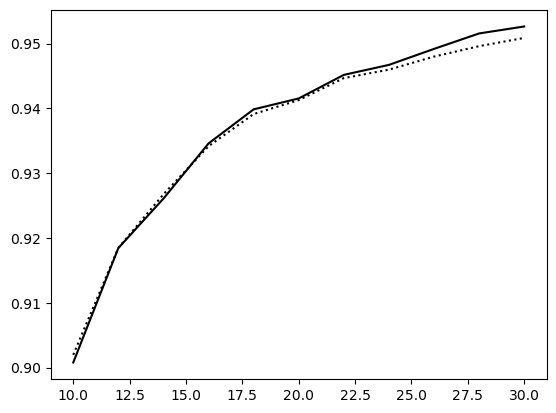

In [9]:
Wtrain=[]
Wtest=[]
X=[10,12,14,16,18,20,22,24,26,28,30]
for modelSize in X:
    Wa=[]
    Wb=[]
    for rep in range(30):
        T=pickle.load(open("dataSize/W_{0}_{1}.p".format(modelSize,rep),'rb'))
        Wa+=T[0]
        Wb+=T[1]
    Wtrain.append(mean(Wa))
    Wtest.append(mean(Wb))
plot(X,Wtrain,'k')
plot(X,Wtest,':k')

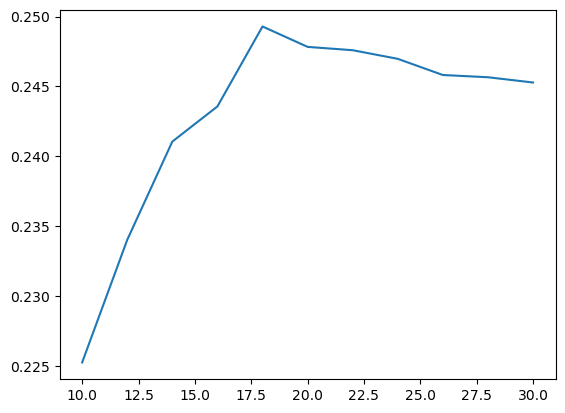

In [14]:
collector=dict()
F=[]
for modelSize in X:
    E=[]
    for rep in range(30):
        model=torch.load("dataSize/model_{0}_{1}.model".format(modelSize,rep))
        accuracies = []
        examples = []
        epsilons = [0, .05, .1, .15, .2, .25, .3]
        # Run test for each epsilon
        for eps in epsilons:
            acc, ex = test(model, test_single, eps)
            accuracies.append(acc)
            examples.append(ex)
        E.append(accuracies)
    E=numpy.array(E)
    collector[modelSize]=E
    F.append(E.mean())
plot(X,F)
#pickle.dump(collector,open("collectorFoolSize.p","wb"))

10 29 1.3876958785717433
12 29 1.3366429404067401
14 29 1.3238303730114527
16 29 1.3096520351301568
18 29 1.2978418168275574
20 29 1.2498012176243463
22 29 1.2000822278286907
24 29 1.1576588305271263
26 29 1.1053123457415563
28 29 1.036452637996406
30 29 0.9893900039762422


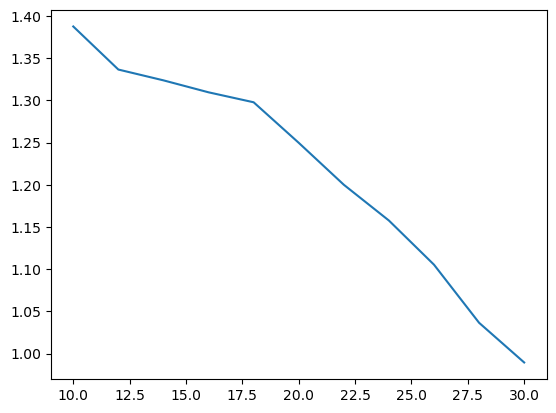

In [26]:
collector=dict()
Y=[]
for modelSize in X:
    sm=[]
    for rep in range(30):
        model=torch.load("dataSize/model_{0}_{1}.model".format(modelSize,rep))
        S,H=shrinkingDecompositionInformation(model,modelSize,test_full)
        M=removalIntoMatrix(S,modelSize,H)
        sm.append(smearedness(M).mean())
    print(modelSize,rep,mean(sm))
    collector[modelSize]=sm
    Y.append(mean(sm))
plot(X,Y)

In [31]:
pickle.dump(collector,open("collectorSmearSize.p","wb"))

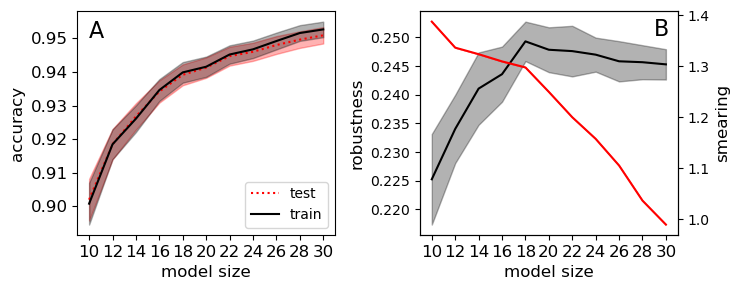

In [82]:
cFool=pickle.load(open("collectorFoolSize.p","rb"))
cSmear=pickle.load(open("collectorSmearSize.p","rb"))
F=[]
S=[]
Wtrain=[]
Wtest=[]
F_e=[]
S_e=[]
Wtrain_e=[]
Wtest_e=[]
X=[10,12,14,16,18,20,22,24,26,28,30]

for modelSize in X:
    f=[]
    s=[]    
    Wa=[]
    Wb=[]
    for rep in range(30):
        f.append(mean(cFool[modelSize][rep]))
        s.append(mean(cSmear[modelSize]))
        T=pickle.load(open("dataSize/W_{0}_{1}.p".format(modelSize,rep),'rb'))
        Wa+=T[0]
        Wb+=T[1]
    Wtrain.append(mean(Wa))
    Wtest.append(mean(Wb))
    F.append(mean(f))
    S.append(mean(s))
    Wtrain_e.append(mean_confidence_interval(Wa))
    Wtest_e.append(mean_confidence_interval(Wb))
    F_e.append(mean_confidence_interval(f))
    S_e.append(mean_confidence_interval(s))
    
F=numpy.array(F)
S=numpy.array(S)
Wtrain=numpy.array(Wtrain)
Wtest=numpy.array(Wtest)
F_e=numpy.array(F_e)
S_e=numpy.array(S_e)
Wtrain_e=numpy.array(Wtrain_e)
Wtest_e=numpy.array(Wtest_e)
    
    
figure(figsize=[7.5,3])
subplot(1,2,1)
fill_between(X,Wtest+Wtest_e,Wtest-Wtest_e,color='r',alpha=0.3)
plot(X,Wtest,':r',label="test")
fill_between(X,Wtrain+Wtrain_e,Wtrain-Wtrain_e,color='k',alpha=0.3)
plot(X,Wtrain,'k',label="train")
legend(loc=4)
xticks(X,["10","12","14","16","18","20","22","24","26","28","30"],fontsize=12)
xlabel("model size",fontsize=12)
ylabel("accuracy",fontsize=12)
yticks(fontsize=12)
text(10,0.95,"A",fontsize=16)

subplot(1,2,2)
fill_between(X,F+F_e,F-F_e,color='k',alpha=0.3)
plot(X,F,'k')
xticks(X,["10","12","14","16","18","20","22","24","26","28","30"],fontsize=12)
xlabel("model size",fontsize=12)
ylabel("robustness",fontsize=12)
twinx()
fill_between(X,S+S_e,S-S_e,color='r',alpha=0.3)
plot(X,S,'r')
ylabel("smearing",fontsize=12)
text(29,1.36,"B",fontsize=16)
tight_layout()
savefig("optimization.pdf")

In [74]:
#HEssian Matrix Stuff

[1.0044304239622697,
 1.0099165234330887,
 0.9496819436255866,
 1.020421221793243,
 0.9960903302432277,
 0.9925630962713342,
 0.9928225399419502,
 1.0026266783381566,
 0.9829848516374207,
 1.039196106205625,
 0.9853066633351779,
 0.9845038885171593,
 1.0205107338311055,
 0.9487488363400423,
 0.9384852571207077,
 1.0261636333558224,
 0.9888065018926145,
 1.0106278478612194,
 0.982454756077607,
 0.9692313233888011,
 1.0058376324721192,
 1.0217124574813456,
 0.9659900791456457,
 0.9825145754257576,
 0.9771337908026326,
 1.0080435480431356,
 0.9842007975418585,
 0.9852117493436463,
 0.9558456048705051,
 0.9496367269884606]

missing 0.3 24
missing 0.3 49


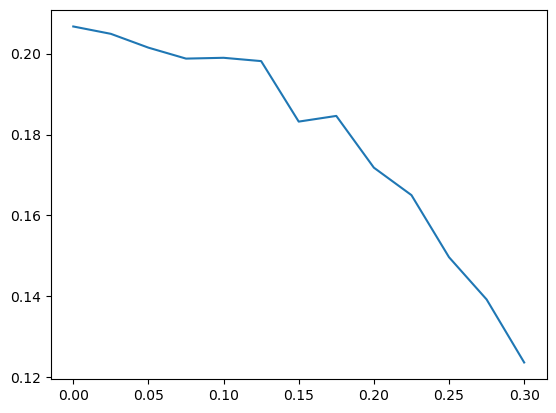

In [328]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
CC=[]
HS=dict()
collectorCC=dict()
As=[]
for d in dr:
    A=[]
    C=[]
    HS[d]=[]
    for n in range(100):
        try:
            Hs=pickle.load(open("data100_model/Hs_{0}_{1}.p".format(d,n),"rb"))
            A.append(numpy.sort(Hs,1).mean(0))
            lc=[]
            for i in range(10):
                for j in range(i+1,10):
                    cc=corrcoef(Hs[i],Hs[j])[0][1]
                    C.append(cc)
                    lc.append(cc)
            collectorCC["{0} {1}".format(d,n)]=mean(lc)
            HS[d].append(numpy.array(Hs).flatten())
        except Exception:
            print("missing",d,n)
    CC.append(mean(C))
figure()
plot(dr,CC)

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_5122/3398522796.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


0.0 0.30020255 0.0020543926
0.025 0.29344052 0.0019488586
0.05 0.24849631 0.0018466117
0.075 0.25397226 0.0018204433
0.1 0.24576828 0.0018062402
0.125 0.2857101 0.001828985
0.15 0.26588678 0.0018505041
0.175 0.29593673 0.0019205819
0.2 0.33097804 0.0019733962
0.225 0.3163185 0.0019885541
0.25 0.44916898 0.0020369797
0.275 0.5328201 0.0020338455
0.3 0.7055293 0.0020477853


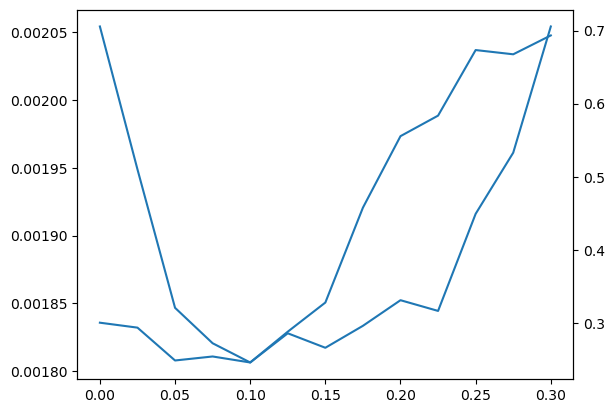

In [212]:

cmap = matplotlib.cm.get_cmap('Spectral')

ms=[]
mmax=[]
dist=[]
for i,d in enumerate(dr):
    av=numpy.abs(numpy.array(HS[d]).flatten())
    H=histogram(av,linspace(0.0,0.1,101))
    print(d,max(av),mean(av))
    ms.append(mean(av))
    mmax.append(max(av))
    dist.append(av)
plot(dr,ms)
twinx()
plot(dr,mmax)

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_5122/3377482443.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


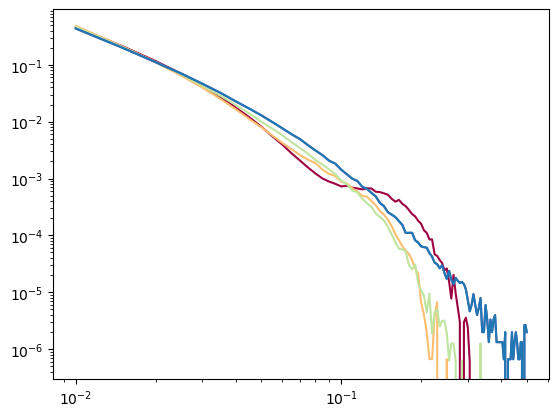

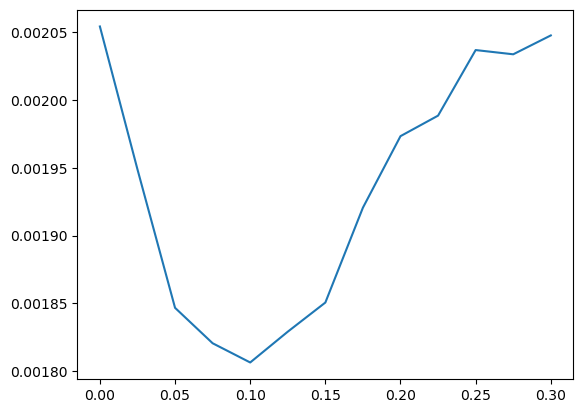

In [275]:

cmap = matplotlib.cm.get_cmap('Spectral')

for i,d in enumerate([0.0,0.1,0.2,0.3]):
    av=numpy.abs(numpy.array(HS[d]).flatten())
    H=histogram(av,linspace(0.0,0.5,101))
    x=H[1][2:]
    y=H[0][1:]/sum(H[0][1:])
    loglog(x,y,color=cmap(linspace(0,1,4)[i]))

loglog(x,y)
figure()
plot(dr,ms)


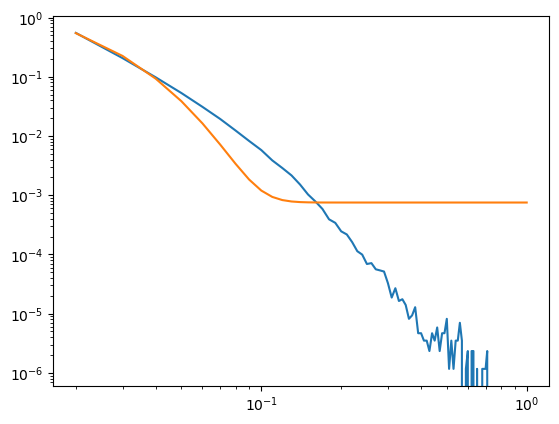

In [274]:
def exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

def weibull(x, k, lambd):
    return (k / lambd) * (x / lambd)**(k - 1) * np.exp(-(x / lambd)**k)

def power_law(x, C, alpha):
    return C * np.power(x, -alpha)

f=exponential
popt, pcov = curve_fit(f, x, y)

loglog(x,y)
loglog(x,f(x,*popt))

In [156]:
from scipy.stats import ks_2samp
D=numpy.zeros((len(dr),len(dr)))
for i in range(len(dr)):
    for j in range(len(dr)):
        statistic, p_value = ks_2samp(dist[i], dist[j])        
        D[i][j]=p_value
        
imshow(D)


KeyboardInterrupt: 

SignificanceResult(statistic=0.42395377670814915, pvalue=9.086812474150499e-58)
[0.78513845 0.01029822]
SignificanceResult(statistic=0.08150629530423296, pvalue=0.003297505331287841)
[0.06088455 0.10004441]


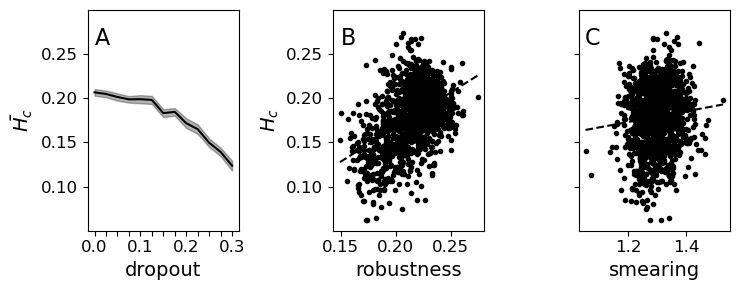

In [329]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
N=100
C=[]
F=[]
Fm=[]
Fme=[]
S=[]
M=[]
Sm=[]
Sme=[]
Me=[]
for d in dr:
    m=[]
    sm=[]
    fm=[]
    for n in range(100):
        try:
            c=collectorCC["{0} {1}".format(d,n)]
            f=collectorF["{0} {1}".format(d,n)]
            s=collectorS["{0} {1}".format(d,n)]
            C.append(c)
            m.append(c)
            F.append(f)
            fm.append(f)
            S.append(s)
            sm.append(s)
        except Exception:
            pass
    M.append(mean(m))
    Me.append(mean_confidence_interval(m))   
    Sm.append(mean(sm))
    Sme.append(mean_confidence_interval(sm))
    Fm.append(mean(fm))
    Fme.append(mean_confidence_interval(fm))

M=numpy.array(M)
Me=numpy.array(Me)
Sm=numpy.array(Sm)
Sme=numpy.array(Sme)
Fm=numpy.array(Fm)
Fme=numpy.array(Fme)
    
figure(figsize=[7.5,3])

#spec = GridSpec(ncols=2, nrows=2,width_ratios=[1,1],height_ratios=[1,1])
spec = GridSpec(ncols=3, nrows=1,width_ratios=[1,1,1])
                         
#subplot(1,3,1)
subplot(spec[0])
fill_between(dr,M+Me,M-Me,color='k',alpha=0.3)
plot(dr,M,'k')
ylabel(r"$\bar{H_{c}}$",fontsize=14)
yticks([0.1,0.15,0.2,0.25],fontsize=12)
ylim(0.05,0.3)
xlabel("dropout",fontsize=14)
xticks(dr,['0.0','','','','0.1','','','','0.2','','','','0.3'],fontsize=12)
text(0.0,0.26,"A",fontsize=16)

#subplot(spec[1])
#fill_between(dr,Fm+Fme,Fm-Fme,color='k',alpha=0.3)
#plot(dr,Fm,'k')
#ylabel(r"$\bar{F}$",fontsize=14)
#yticks(fontsize=12)
#xlabel("dropout",fontsize=14)
#xticks(dr,['0.0','','','','0.1','','','','0.2','','','','0.3'],fontsize=12)
#text(0.28,0.225,"B",fontsize=16)

#subplot(1,3,2)
subplot(spec[1])
plot(F,C,'.k')
ylim(0.05,0.3)

print(stats.spearmanr(F,C))
v=numpy.polyfit(F,C,1)
x=linspace(min(F),max(F),11)
plot(x,numpy.polyval(v,x),'--k')
print(v)
ylabel(r"$H_{c}$",fontsize=14)
xlabel("robustness",fontsize=14)
text(0.15,0.26,"B",fontsize=16)
xticks(fontsize=12)
#yticks([0.1,0.15,0.2,0.25],[""]*4)
yticks([0.1,0.15,0.2,0.25],fontsize=12)

#subplot(2,2,3)
#fill_between(dr,Sm+Sme,Sm-Sme,color='k',alpha=0.3)
#plot(dr,Sm,'k')

#subplot(1,3,3)
subplot(spec[2])

plot(S,C,'.k')
print(stats.spearmanr(S,C))
v=numpy.polyfit(S,C,1)
x=linspace(min(S),max(S),11)
plot(x,numpy.polyval(v,x),'--k')
print(v)
xlabel("smearing",fontsize=14)
text(1.05,0.26,"C",fontsize=16)
#ylabel(r"$H_{c}$",fontsize=14)
xticks(fontsize=12)
#yticks([0.1,0.15,0.2,0.25],fontsize=12)
yticks([0.1,0.15,0.2,0.25],[""]*4)
ylim(0.05,0.3)
tight_layout()
savefig("HcRobSm.pdf")

In [156]:
model=ComposedNet(28*28,20,10)
optimizer = optim.Adam(model.parameters(),lr=0.001)
error = nn.MSELoss()
acc=0.0
Wtest=[]
Wtrain=[]
for epoch in range(50):
    for image,target in train_batch:
        optimizer.zero_grad()
        targets=numpy.zeros((1000,10))-1.0
        for i,t in enumerate(target):
            targets[i][t]=1.0
        output = model(torch.Tensor(image))
        loss = error(output, torch.Tensor(targets))
        loss.backward()
        optimizer.step()
    print("train",testOnAllTen(model,imageNumberDataSet))        
    print("test",testOnAllTen(model,testImageNumberDataSet,howMany=800))    

train [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.513, 0.5, 0.5]
test [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.513125, 0.5, 0.5]
train [0.6525, 0.8725, 0.5935, 0.766, 0.5085, 0.5, 0.6115, 0.8255, 0.5, 0.5]
test [0.665625, 0.885625, 0.584375, 0.765625, 0.51, 0.5, 0.59125, 0.820625, 0.5, 0.5]
train [0.836, 0.951, 0.784, 0.8305, 0.659, 0.588, 0.842, 0.868, 0.5, 0.5]
test [0.8425, 0.95625, 0.78125, 0.84, 0.68, 0.58125, 0.834375, 0.88125, 0.5, 0.5]
train [0.8955, 0.9675, 0.8055, 0.8435, 0.773, 0.6755, 0.897, 0.877, 0.5, 0.5]
test [0.889375, 0.973125, 0.814375, 0.860625, 0.78, 0.681875, 0.900625, 0.893125, 0.5, 0.500625]
train [0.9125, 0.9725, 0.8485, 0.8635, 0.83, 0.7735, 0.917, 0.9055, 0.5035, 0.5435]
test [0.914375, 0.975, 0.84375, 0.88125, 0.828125, 0.78125, 0.915, 0.90625, 0.5, 0.55375]
train [0.933, 0.9705, 0.862, 0.8855, 0.868, 0.8015, 0.933, 0.9125, 0.668, 0.647]
test [0.94, 0.97875, 0.861875, 0.87625, 0.855625, 0.81125, 0.91875, 0.90875, 0.659375, 0.670625]
train [0.936, 0.9675, 0.888, 0.888

train [0.981, 0.982, 0.949, 0.9435, 0.9655, 0.933, 0.973, 0.971, 0.934, 0.9565]
test [0.98125, 0.9875, 0.9525, 0.9525, 0.960625, 0.9225, 0.9525, 0.959375, 0.935625, 0.953125]
train [0.981, 0.9825, 0.9595, 0.94, 0.9665, 0.934, 0.9785, 0.977, 0.931, 0.957]
test [0.9825, 0.9875, 0.955625, 0.943125, 0.954375, 0.915, 0.963125, 0.963125, 0.930625, 0.954375]
train [0.978, 0.9815, 0.955, 0.946, 0.968, 0.937, 0.972, 0.9695, 0.932, 0.9535]
test [0.9825, 0.986875, 0.94625, 0.94375, 0.956875, 0.9175, 0.96125, 0.9575, 0.934375, 0.948125]


In [ ]:
models=[ComposedNet(28*28,20,10),ComposedNet(28*28,20,10)]
optimizers = [optim.Adam(models[0].parameters(),lr=0.001),optim.Adam(models[1].parameters(),lr=0.001)]
error = nn.MSELoss()
acc=0.0
Wtrain=[]
Wtest=[]
count=0
SM=[]
Ws=[]
Fs=[]

for epoch in range(50):
    for o,model in enumerate(models):
        for image,target in train_batch:
            optimizers[o].zero_grad()
            targets=numpy.zeros((1000,10))-1.0
            for i,t in enumerate(target):
                targets[i][t]=1.0
            output = model(torch.Tensor(image))
            loss = error(output, torch.Tensor(targets))
            loss.backward()
            optimizers[o].step()
    S=[0,0]
    H=[0,0]
    W=[0,0]
    F=[0,0]
    score=[0,0]
    sm=[]
    for o in range(2):
        S[o],H[o]=shrinkingDecompositionInformation(models[o],20,test_full)
        M=removalIntoMatrix(S[o],20,H[o])
        sm.append(smearedness(M).mean())
        W[o]=mean(testOnAllTen(models[o],imageNumberDataSet))
        score[o]=W[o]/sm[o]
        accuracies = []
        # Run test for each epsilon
        for eps in [0, .05, .1, .15, .2, .25, .3]:
            acc, ex = test(models[0], test_single, eps)
            accuracies.append(acc)
        F[o]=mean(accuracies)
        
    print(epoch,sm,W,score,F)
    SM.append(sm)
    Ws.append(W)
    Fs.append(F)
    if score[0]>score[1]:
        source=models[0]
        target=models[1]
    else:
        source=models[1]
        target=models[0]
    if True:
        weights=source.state_dict()
        for k in weights.keys():
            W=weights[k]
            M=torch.Tensor(W+numpy.random.normal(0.0,0.001,W.shape))
            weights[k]=M
        target.load_state_dict(weights)
        

0 [1.6609320216880499, 1.7217082413603255] [0.55255, 0.5772999999999999] [0.332674662650208, 0.3353065206587348] [0.17137142857142856, 0.17137142857142856]
1 [1.4540184079902103, 1.495848093560138] [0.7016, 0.7270499999999999] [0.4825248402252166, 0.486045343193647] [0.24734285714285711, 0.24734285714285711]
2 [1.4639852690988517, 1.4022685988603212] [0.81775, 0.8189] [0.5585780248344723, 0.5839822703478864] [0.25957142857142856, 0.25957142857142856]
3 [1.3670674858832803, 1.3671028894790767] [0.8583999999999999, 0.86615] [0.627913405054306, 0.6335660663624516] [0.25912857142857143, 0.25912857142857143]
4 [1.337950480799925, 1.3155701435693385] [0.8844, 0.8838500000000001] [0.6610110110138312, 0.6718379892705553] [0.25698571428571426, 0.25698571428571426]
5 [1.2749182158104457, 1.3366650801961892] [0.9017499999999998, 0.8989499999999999] [0.7073002713564426, 0.672531970288366] [0.2554571428571429, 0.2554571428571429]
6 [1.2367762813954655, 1.261400612049499] [0.9058000000000002, 0.9121

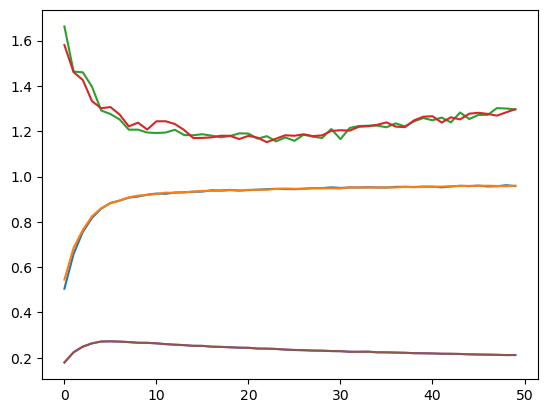

In [286]:
plot(Ws)
plot(SM)
plot(Fs)

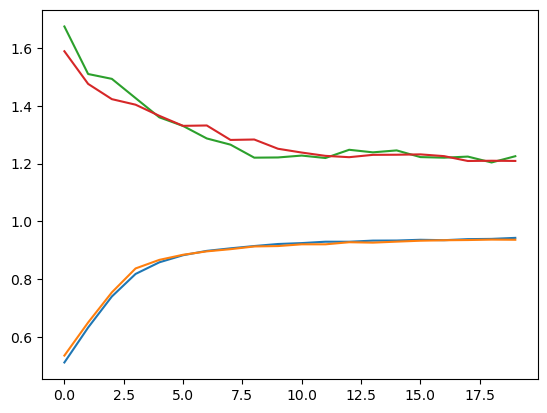

In [276]:
plot(Ws)
plot(SM)

In [235]:
model.load_state_dict(torch.load("composedModel/composedModel.model"))

<All keys matched successfully>

In [236]:
S,H=shrinkingDecompositionInformation(model,20,test_full)

smearedness [1.13624295 0.73802771 0.27528623 0.02412317 1.81522908 2.62243289
 1.31106903 1.37031012 1.10190621 0.60565925 2.63052148 3.48942288
 0.98212247 0.48297234 1.21458575 0.72543416 2.75225794 3.7530391
 2.28717387 2.8768868 ]
1.6097351710161916


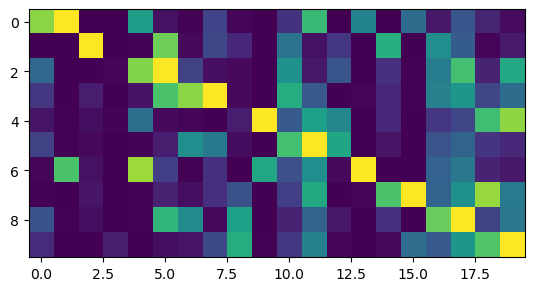

In [237]:

#imshow(removalIntoMatrix(dataS[0],20,dataS[1]))
M=removalIntoMatrix(S,20,H)
imshow(removalIntoMatrix(S,20,H))
print("smearedness",smearedness(M))
composedSmear=smearedness(M).mean()
print(composedSmear)

In [238]:
weights

ComposedNet(
  (hiddenLayer): Linear(in_features=784, out_features=20, bias=True)
  (outputLayer): Linear(in_features=20, out_features=10, bias=True)
  (do): Dropout(p=0.0, inplace=False)
)

In [222]:
model.state_dict()

OrderedDict([('hiddenLayer.weight',
              tensor([[-0.0010,  0.0178, -0.0050,  ..., -0.0288,  0.0302, -0.0306],
                      [-0.0152, -0.0283,  0.0151,  ..., -0.0263,  0.0242,  0.0256],
                      [ 0.0174, -0.0027,  0.0309,  ...,  0.0119,  0.0174,  0.0296],
                      ...,
                      [ 0.0344,  0.0120,  0.0342,  ..., -0.0241, -0.0121, -0.0321],
                      [ 0.0248,  0.0244,  0.0083,  ..., -0.0132,  0.0020, -0.0011],
                      [ 0.0247, -0.0240, -0.0308,  ...,  0.0003, -0.0254, -0.0028]])),
             ('hiddenLayer.bias',
              tensor([-0.0221,  0.0092,  0.0065,  0.0299,  0.0054,  0.0304,  0.0175,  0.0329,
                       0.0095,  0.0195, -0.0334, -0.0254, -0.0338, -0.0253, -0.0091,  0.0328,
                      -0.0346, -0.0341,  0.0063,  0.0247])),
             ('outputLayer.weight',
              tensor([[ 2.0071e-01,  1.1648e-01, -4.6023e-02, -1.8254e-01,  1.6394e-01,
                       

(2.8284271247461907, 1.0)
(4.0, 1.0)
(4.699206266551611, 1.0)


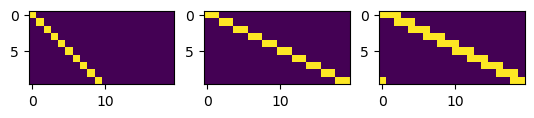

In [5]:

def calculate_cluster_strength(M):
    c, n = M.shape  # c: number of clusters, n: number of nodes
    
    # Calculate Inter-Cluster Strength
    inter_cluster_strength = 0.0
    pairwise_combinations = c * (c - 1) / 2  # Total number of pairwise combinations of clusters

    # Calculate dissimilarity matrix
    dissimilarity_matrix = numpy.zeros((c, c))
    for i in range(c):
        for j in range(i+1, c):
            dissimilarity_matrix[i][j] = numpy.linalg.norm(M[i] - M[j])
            dissimilarity_matrix[j][i] = dissimilarity_matrix[i][j]

    # Calculate average dissimilarity between clusters
    inter_cluster_strength = numpy.sum(dissimilarity_matrix) / pairwise_combinations

    # Calculate Intra-Cluster Strength
    intra_cluster_strength = numpy.mean(numpy.sum(M, axis=1) / numpy.sum(M != 0, axis=1))

    return inter_cluster_strength, intra_cluster_strength

M=numpy.zeros((10,20))
for i in range(10):
    M[i][i]=1.0
print(calculate_cluster_strength(M))
subplot(1,3,1)
imshow(M)

M=numpy.zeros((10,20))
for i in range(10):
    M[i][i*2]=1.0
    M[i][i*2+1]=1.0
print(calculate_cluster_strength(M))
subplot(1,3,2)
imshow(M)

M=numpy.zeros((10,20))
for i in range(10):
    M[i][i*2]=1.0
    M[i][i*2+1]=1.0
    M[i][(i*2+2)%20]=1.0
print(calculate_cluster_strength(M))
subplot(1,3,3)
imshow(M)
    


In [7]:
images

NameError: name 'images' is not defined

In [4]:
for image,target in train_batch:
    pass

In [5]:
image.shape

torch.Size([1000, 1, 28, 28])

In [8]:
ri=transforms.functional.rotate(image,90)
ri.shape

torch.Size([1000, 1, 28, 28])

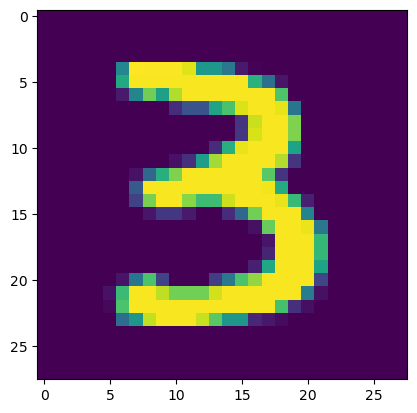

In [9]:
imshow(image[0][0])

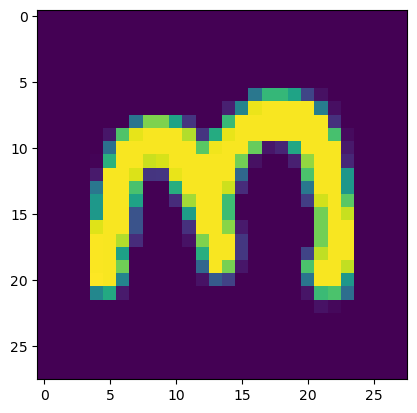

In [11]:
imshow(ri[0][0])